In [1]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import statsmodels as sms





### Section 1: Data Wrangling

In [2]:
#NEW
with open('lol_data.json', 'r') as file:
   newdata = json.load(file)

With the JSON file loaded, I immediately turned it into a dataframe and checked its dimensions.

In [3]:
#NEW
newdf = pd.DataFrame(newdata)
newdf.shape

(882, 13)

In [4]:
#NEW
newdf.head()

,gameCreation,gameDuration,gameId,gameMode,gameType,gameVersion,mapId,participantIdentities,participants,platformId,queueId,seasonId,teams
0,1546074305758,873,2942016788,ARAM,MATCHED_GAME,8.24.255.8524,12,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,450,11,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T..."
1,1546072056795,1836,2942003298,CLASSIC,MATCHED_GAME,8.24.255.8524,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,400,11,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ..."
2,1546070609011,1023,2942000078,CLASSIC,MATCHED_GAME,8.24.255.8524,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,420,11,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ..."
3,1546063787803,2030,2941949842,CLASSIC,MATCHED_GAME,8.24.255.8524,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,420,11,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T..."
4,1546061423214,1930,2941921008,CLASSIC,MATCHED_GAME,8.24.255.8524,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,420,11,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ..."


The columns that I care about here are 'gameMode' and 'participantidentities'. League of Legends has a few game modes, but we are interested in the CLASSIC mode, which is the most popular and competitive mode. Each row can be thought of as a game that occurred. 

In [5]:
#NEW
newgames = newdf[['participants','gameMode']]
newgames.head()

,participants,gameMode
0,"[{'participantId': 1, 'teamId': 100, 'champion...",ARAM
1,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC
2,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC
3,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC
4,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC


In [6]:
# We only want games on the Summoner's Rift map (CLASSIC) 
newclassicgames = newgames[newgames['gameMode'] == 'CLASSIC']['participants']
newclassicgames.head()

1    [{'participantId': 1, 'teamId': 100, 'champion...
2    [{'participantId': 1, 'teamId': 100, 'champion...
3    [{'participantId': 1, 'teamId': 100, 'champion...
4    [{'participantId': 1, 'teamId': 100, 'champion...
5    [{'participantId': 1, 'teamId': 100, 'champion...
Name: participants, dtype: object

Above is an example of all the stats and data have from one game (row). There are five players on each of two teams, making a total of 10 players (10 'participantIds"). Like newclassicgames[1], each game is simply a list of 10 dictionaries, one dictionary per player. 

In [7]:
newclassicgames[1]

[{'participantId': 1,
  'teamId': 100,
  'championId': 223,
  'spell1Id': 14,
  'spell2Id': 4,
  'highestAchievedSeasonTier': 'UNRANKED',
  'stats': {'participantId': 1,
   'win': False,
   'item0': 3190,
   'item1': 3401,
   'item2': 3009,
   'item3': 3067,
   'item4': 0,
   'item5': 0,
   'item6': 3340,
   'kills': 2,
   'deaths': 10,
   'assists': 4,
   'largestKillingSpree': 0,
   'largestMultiKill': 1,
   'killingSprees': 0,
   'longestTimeSpentLiving': 433,
   'doubleKills': 0,
   'tripleKills': 0,
   'quadraKills': 0,
   'pentaKills': 0,
   'unrealKills': 0,
   'totalDamageDealt': 27896,
   'magicDamageDealt': 8606,
   'physicalDamageDealt': 8015,
   'trueDamageDealt': 11274,
   'largestCriticalStrike': 0,
   'totalDamageDealtToChampions': 6856,
   'magicDamageDealtToChampions': 5389,
   'physicalDamageDealtToChampions': 732,
   'trueDamageDealtToChampions': 734,
   'totalHeal': 4088,
   'totalUnitsHealed': 5,
   'damageSelfMitigated': 29510,
   'damageDealtToObjectives': 510,
 

In [8]:
# NEW
newgames.head()

,participants,gameMode
0,"[{'participantId': 1, 'teamId': 100, 'champion...",ARAM
1,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC
2,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC
3,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC
4,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC


Below, I created a function that takes in a game, and converts the list of dictionaries into a Pandas row, or a dataframe object.   

In [9]:
# Why does this run slow?

# Below is a list of keys that I want to keep
stats_keep_columns = ['participantId','win','item0','item1','item2','item3','item4','item5',
'item6','kills','deaths','assists','longestTimeSpentLiving','totalDamageDealtToChampions',
'magicDamageDealtToChampions', 'physicalDamageDealtToChampions','trueDamageDealtToChampions',
'damageDealtToTurrets','visionScore','timeCCingOthers','goldEarned','turretKills',
'perk0','perk1','perk2', 'perk3', 'perk4', 'perk5']

def create_row(row):
    '''Unpacks each list of dictionaries, from each CLASSIC game, to create a pandas row.
    Each row is organized such that the features of the winning team are displayed to the 
    left.'''
      
    a_row = []   
    for players in row:
        stats_player = pd.DataFrame.from_dict(players['stats'], orient = 'index') #Turns the dict into a pandas row
        a_row.append(stats_player.T[stats_keep_columns]) #Transposes then extracts 
        champ_player = pd.DataFrame.from_dict(dict((list(players.items())[2],)), orient = 'index')
        a_row.append(champ_player.T) #Adds in the champion each player played
        the_row = pd.concat(a_row, axis = 1)
    
    # The code below organizes each row such that the stats on the first five players are always of the winners
    player_indexes = [index for index, col_name in enumerate(the_row) if col_name == 'participantId']
    if the_row.iloc[:,1].bool() == False:           
        losers = the_row.iloc[:,:player_indexes[5]]     
        the_row = pd.concat([the_row, losers], axis = 1)
        the_row = the_row.iloc[:,player_indexes[5]:]        
    the_row = the_row.drop('win',axis=1) #Drops the win columns
    return the_row 

    
newclassicwoof = newclassicgames.apply(create_row)
newclassicwoof

1        participantId item0 item1 item2 item3 item4 ...
2        participantId item0 item1 item2 item3 item4 ...
3        participantId item0 item1 item2 item3 item4 ...
4        participantId item0 item1 item2 item3 item4 ...
5        participantId item0 item1 item2 item3 item4 ...
6        participantId item0 item1 item2 item3 item4 ...
7        participantId item0 item1 item2 item3 item4 ...
8        participantId item0 item1 item2 item3 item4 ...
9        participantId item0 item1 item2 item3 item4 ...
10       participantId item0 item1 item2 item3 item4 ...
11       participantId item0 item1 item2 item3 item4 ...
12       participantId item0 item1 item2 item3 item4 ...
13       participantId item0 item1 item2 item3 item4 ...
14       participantId item0 item1 item2 item3 item4 ...
15       participantId item0 item1 item2 item3 item4 ...
16       participantId item0 item1 item2 item3 item4 ...
17       participantId item0 item1 item2 item3 item4 ...
18       participantId item0 it

The output of the previous cell does not look very glamourous, but if we look at each row individually, we can see each game now looks like a single-row dataframe, which can be concatenated as seen in upcoming cells. 

In [10]:
newclassicwoof[2]

,participantId,item0,item1,item2,item3,item4,item5,item6,kills,deaths,...,timeCCingOthers,goldEarned,turretKills,perk0,perk1,perk2,perk3,perk4,perk5,championId
0,6,2003,0,1052,1001,3285,1056,3340,1,1,...,10,4296,0,8010,9111,9104,8014,8304,8352,24


In [11]:
chunks = []
for chunk in newclassicwoof:
        chunks.append(chunk)    
yes = pd.concat(chunks)

new_names = []
player_indexes = [index for index, col_name in enumerate(yes) if col_name == 'participantId']
yes = yes.drop('participantId', axis=1)

for player in range(5):
    if player != 0:
        wp = yes.iloc[:,player_indexes[player]:player_indexes[player+1]].add_prefix('WP'+str(player+1)+'_')
        new_names.append(wp)
    else:
        wp =yes.iloc[:,:player_indexes[player+1]].add_prefix('WP'+str(player+1)+'_')
        new_names.append(wp)
        
for player in range(5,10):
    if player != 9:
        lp = yes.iloc[:,player_indexes[player]:player_indexes[player+1]].add_prefix('LP'+str(player-4)+'_')
        new_names.append(lp)
    else:
        yes.iloc[:,player_indexes[player]:].add_prefix('LP'+str(player-4)+'_')

yes = pd.concat(new_names, axis=1)
yes.reset_index(drop=True).head()

,WP1_item0,WP1_item1,WP1_item2,WP1_item3,WP1_item4,WP1_item5,WP1_item6,WP1_kills,WP1_deaths,WP1_assists,...,LP4_championId,LP4_item0,LP4_item1,LP4_item2,LP4_item3,LP4_item4,LP4_item5,LP4_item6,LP4_kills,LP4_deaths
0,3040,3020,3285,1056,3135,0,3363,11,1,6,...,7,1400,2033,3071,3158,1029,1011,3340,4,9
1,2003,0,1052,1001,3285,1056,3340,1,1,4,...,267,2033,3211,1055,3111,3044,0,3340,0,5
2,2031,3143,3050,3401,3047,2055,3364,3,8,22,...,412,3071,1033,3065,3047,3075,3211,3340,6,7
3,3020,3146,3157,3113,0,0,3340,5,7,6,...,157,3401,2420,3147,1031,3117,3742,3364,8,4
4,3222,3107,3098,3041,3504,3111,3363,3,10,31,...,19,1026,3152,3100,1082,3020,3165,3340,14,11


After concatenating the Pandas rows into one single dataframe with the column headers preserved. The header names are changed to make clear for which player does the column refer.

In [ ]:
#### Need to fix this 

chunks = []
for chunk in newclassicwoof:
    chunks.append(chunk)    
yes = pd.concat(chunks)

player_indexes = [index for index, col_name in enumerate(yes) if col_name == 'participantId']
yes = yes.drop('participantId', axis=1)

wp_1 = yes.iloc[:,:player_indexes[1]].add_prefix('WP1_')
wp_2 = yes.iloc[:,player_indexes[1]:player_indexes[2]].add_prefix('WP2_')
wp_3 = yes.iloc[:,player_indexes[2]:player_indexes[3]].add_prefix('WP3_')
wp_4 = yes.iloc[:,player_indexes[3]:player_indexes[4]].add_prefix('WP4_')
wp_5 = yes.iloc[:,player_indexes[4]:player_indexes[5]].add_prefix('WP5_')

lp_1 = yes.iloc[:,player_indexes[5]:player_indexes[6]].add_prefix('LP1_')
lp_2 = yes.iloc[:,player_indexes[6]:player_indexes[7]].add_prefix('LP2_')
lp_3 = yes.iloc[:,player_indexes[7]:player_indexes[8]].add_prefix('LP3_')
lp_4 = yes.iloc[:,player_indexes[8]:player_indexes[9]].add_prefix('LP4_')
lp_5 = yes.iloc[:,player_indexes[9]:].add_prefix('LP5_')

new_names = [wp_1, wp_2, wp_3, wp_4, wp_5, lp_1, lp_2, lp_3, lp_4, lp_5]
yes = pd.concat(new_names, axis=1)
yes.reset_index(drop=True).head()

Another dataframe, 'team', is made where each row still represents a game, but with the munerical stats aggregated based on the winning and losing team.  

In [12]:
#TEAM DATA

agg = ['kills', 'deaths', 'assists', 'physicalDamageDealtToChampions', 'magicDamageDealtToChampions',
       'trueDamageDealtToChampions','totalDamageDealtToChampions', 'timeCCingOthers', 'visionScore',
       'longestTimeSpentLiving', 'goldEarned', 'damageDealtToTurrets']

team = pd.DataFrame()

for feature in agg: 
    team['Win_'+ feature] = yes[[col for col in yes.columns if 'WP' in col and feature in col]].sum(axis=1)
    team['Lose_'+ feature] = yes[[col for col in yes.columns if 'LP' in col and feature in col]].sum(axis=1)
team['TurretDamageDiff'] = team['Win_damageDealtToTurrets'] - team['Lose_damageDealtToTurrets']
team.reset_index(drop=True).head()

,Win_kills,Lose_kills,Win_deaths,Lose_deaths,Win_assists,Lose_assists,Win_physicalDamageDealtToChampions,Lose_physicalDamageDealtToChampions,Win_magicDamageDealtToChampions,Lose_magicDamageDealtToChampions,...,Lose_timeCCingOthers,Win_visionScore,Lose_visionScore,Win_longestTimeSpentLiving,Lose_longestTimeSpentLiving,Win_goldEarned,Lose_goldEarned,Win_damageDealtToTurrets,Lose_damageDealtToTurrets,TurretDamageDiff
0,35.0,19.0,14.0,53.0,51.0,12.0,19575.0,23692.0,60725.0,16448.0,...,87.0,152.0,62.0,3174.0,2843.0,59728.0,37129.0,25144.0,5222.0,19922.0
1,21.0,7.0,4.0,28.0,23.0,8.0,21335.0,4028.0,14970.0,10658.0,...,15.0,58.0,30.0,2073.0,1433.0,38943.0,17334.0,26203.0,131.0,26072.0
2,45.0,40.0,35.0,64.0,76.0,51.0,56356.0,45953.0,67135.0,29486.0,...,107.0,176.0,124.0,3307.0,1274.0,67959.0,48900.0,19576.0,6752.0,12824.0
3,37.0,32.0,25.0,49.0,46.0,28.0,71227.0,58302.0,25272.0,8246.0,...,78.0,165.0,99.0,3847.0,2672.0,67811.0,46901.0,28886.0,8206.0,20680.0
4,51.0,60.0,43.0,76.0,88.0,53.0,107904.0,79667.0,45334.0,36908.0,...,180.0,130.0,170.0,2361.0,1726.0,73771.0,52917.0,24600.0,12613.0,11987.0


### Section 2: Exploratory Data Analysis

Below are results of stats comparaisons between winning and losing team. For the most part, the stats look fairly even... 

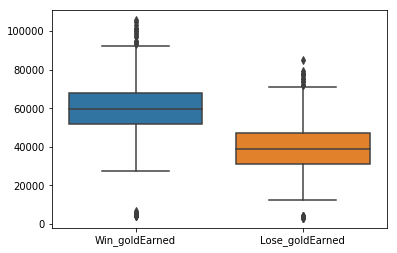

In [13]:
sns.boxplot(data=team[['Win_goldEarned','Lose_goldEarned']]);

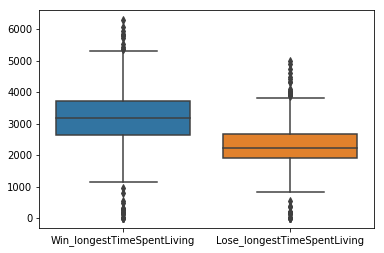

In [14]:
sns.boxplot(data=team[['Win_longestTimeSpentLiving','Lose_longestTimeSpentLiving']]);

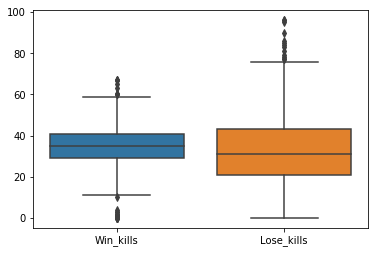

In [15]:
sns.boxplot(data=team[['Win_kills','Lose_kills']]);

In [ ]:
sns.boxplot(data=team[['Win_visionScore','Lose_visionScore']]);

In [ ]:
sns.boxplot(data=team[['Win_timeCCingOthers','Lose_timeCCingOthers']]);

In [ ]:
sns.boxplot(data=team[['Win_physicalDamageDealtToChampions','Lose_physicalDamageDealtToChampions']]);

In [ ]:
sns.boxplot(data=team[['Win_magicDamageDealtToChampions','Lose_magicDamageDealtToChampions']]);

In [ ]:
sns.boxplot(data=team[['Win_trueDamageDealtToChampions','Lose_trueDamageDealtToChampions']]);

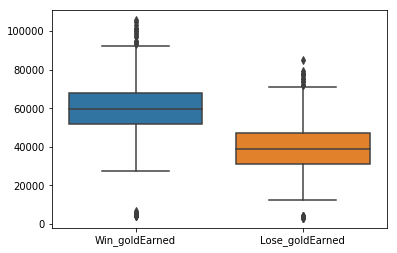

In [16]:
sns.boxplot(data=team[['Win_goldEarned','Lose_goldEarned']]);

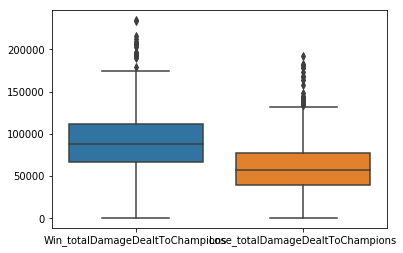

In [17]:
sns.boxplot(data=team[['Win_totalDamageDealtToChampions','Lose_totalDamageDealtToChampions']]);

## ...Except...

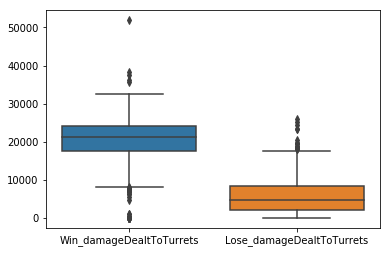

In [18]:
sns.boxplot(data=team[['Win_damageDealtToTurrets','Lose_damageDealtToTurrets']]);

It would appear that teams that win tend to be those that do much more Turret Damage, or at least much more compared to the losing team. This makes sense due to the fact that the goal of each game is to destroy the enemy nexus. The only way to get closer to the nexus is by destorying the turrets that are along the way. While getting kills, gold, vision, dragons etc... are absolutely helpful, they are secondary objectives, and technically not mandatory for getting closer to the nexus, while destroying turrets is indeed essential.   

I created a correlation heatmap that shows the Pearson's correlation coefficient to compare the winning team's stats to see if perhaps there are other specific stats that strongly correlate with turret damage. We can see in the last row of the map that number of kills and gold earned are the strongest correlators. 



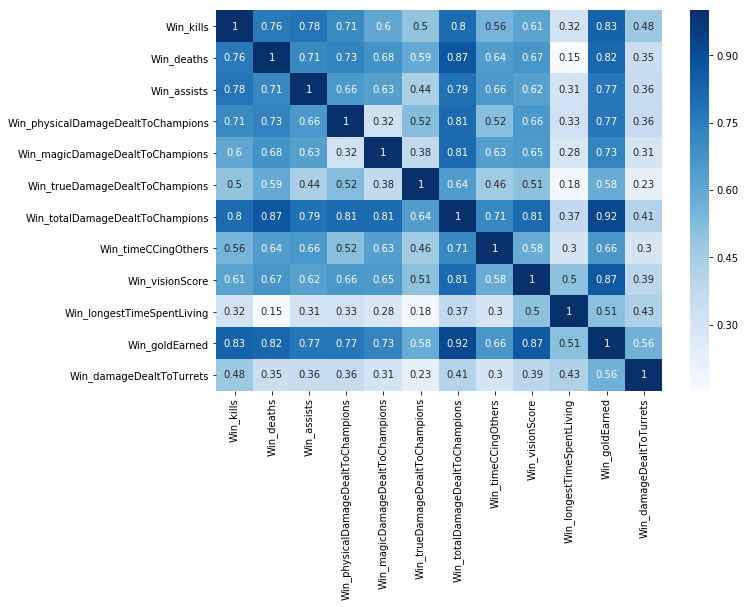

In [19]:
winners = team[[col for col in team.columns if 'Win' in col]]

plt.figure(figsize=(10, 7))
sns.heatmap(winners.corr(), annot=True, cmap='Blues');              

In [ ]:
losers = team[[col for col in team.columns if 'Lose' in col]]

plt.figure(figsize=(10, 7))
sns.heatmap(losers.corr(), annot=True, cmap='Oranges');  

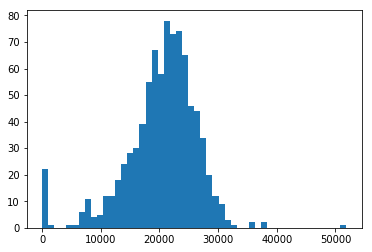

In [20]:
plt.hist(team['Win_damageDealtToTurrets'],bins=50);


The Riot API is formatted such that championIDs and Rune IDs are framed as integers, as seen below. 

In [21]:
# Extracting the champID columns

champ_indexes = [col for col in yes.columns if 'championId' in col]  

champ_columns = yes[champ_indexes].reset_index(drop=True)
champ_columns.head()

,WP1_championId,WP2_championId,WP3_championId,WP4_championId,WP5_championId,LP1_championId,LP2_championId,LP3_championId,LP4_championId
0,45,35,103,516,40,223,51,78,7
1,103,81,27,80,222,18,102,4,267
2,89,245,145,77,2,120,236,34,412
3,55,141,18,497,23,5,236,58,157
4,16,236,45,75,120,412,81,86,19


By accessing other Riot API endpoint, I was able to access the JSON files that associated their integers to their names. 

In [22]:
url_champ = 'http://ddragon.leagueoflegends.com/cdn/8.24.1/data/en_US/champion.json'
champion_info = requests.get(url_champ).json()

url_rune = 'http://ddragon.leagueoflegends.com/cdn/8.24.1/data/en_US/runesReforged.json'
rune_info = requests.get(url_rune).json()

As an example, we can see below that the champion, Aatrox, is framed under the integer, 266. The key-value pairs we care about are such where keys = 'id' and 'name'.

In [23]:
champion_info['data']['Aatrox']

{'version': '8.24.1',
 'id': 'Aatrox',
 'key': '266',
 'name': 'Aatrox',
 'title': 'the Darkin Blade',
 'blurb': 'Once honored defenders of Shurima against the Void, Aatrox and his brethren would eventually become an even greater threat to Runeterra, and were defeated only by cunning mortal sorcery. But after centuries of imprisonment, Aatrox was the first to find...',
 'info': {'attack': 8, 'defense': 4, 'magic': 3, 'difficulty': 4},
 'image': {'full': 'Aatrox.png',
  'sprite': 'champion0.png',
  'group': 'champion',
  'x': 0,
  'y': 0,
  'w': 48,
  'h': 48},
 'tags': ['Fighter', 'Tank'],
 'partype': 'Blood Well',
 'stats': {'hp': 580,
  'hpperlevel': 80,
  'mp': 0,
  'mpperlevel': 0,
  'movespeed': 345,
  'armor': 33,
  'armorperlevel': 3.25,
  'spellblock': 32.1,
  'spellblockperlevel': 1.25,
  'attackrange': 175,
  'hpregen': 5,
  'hpregenperlevel': 0.25,
  'mpregen': 0,
  'mpregenperlevel': 0,
  'crit': 0,
  'critperlevel': 0,
  'attackdamage': 60,
  'attackdamageperlevel': 5,
  '

In [24]:
# key_to_champ: Dictionary with the championID as keys and champion name as values  

champ_list = list(champion_info['data'].keys())

champ_keys = []
for champ in champ_list:
    key = champion_info['data'][champ]['key']
    champ_keys.append(int(key))
champ_keys

champ_to_key = dict(zip(champ_list, champ_keys))

list(champ_to_key.items())[:10] #The 'head' of the dictionary

[('Aatrox', 266),
 ('Ahri', 103),
 ('Akali', 84),
 ('Alistar', 12),
 ('Amumu', 32),
 ('Anivia', 34),
 ('Annie', 1),
 ('Ashe', 22),
 ('AurelionSol', 136),
 ('Azir', 268)]

In [25]:
champ_to_key['Ziggs']

115

In [26]:
# key_to_rune: Dictionary with the RuneID as keys and rune name as values

rune_to_key = {}

for rune_path in rune_info:
    for rune_line in rune_path['slots']:
        for rune in rune_line['runes']:
            rune_to_key[rune['key']] = rune['id']
            
list(rune_to_key.items())[:10] #The 'head' of the dictionary

[('Electrocute', 8112),
 ('Predator', 8124),
 ('DarkHarvest', 8128),
 ('HailOfBlades', 9923),
 ('CheapShot', 8126),
 ('TasteOfBlood', 8139),
 ('SuddenImpact', 8143),
 ('ZombieWard', 8136),
 ('GhostPoro', 8120),
 ('EyeballCollection', 8138)]

In [27]:
#Generate a sample of games that Does have Tristana
turrets = ['Win_damageDealtToTurrets','Lose_damageDealtToTurrets','TurretDamageDiff']

trist_index = []
trist_wins = 0
win_check = 5
for index, row in champ_columns.iterrows():
    for position, key in enumerate(row):
        if key == champ_to_key['Tristana']:
            trist_index.append(index)
            if position < win_check:
                trist_wins += 1 # We know the winners are represented by the first 5 columns
            break 

trist_games = team[turrets].reset_index(drop=True).iloc[trist_index,:]
trist_games = trist_games[~np.all(trist_games == 0, axis=1)]
print("Tristana's winrate is",trist_wins/trist_games.shape[0])
trist_games.head()

Tristana's winrate is 0.5072463768115942


,Win_damageDealtToTurrets,Lose_damageDealtToTurrets,TurretDamageDiff
1,26203.0,131.0,26072.0
3,28886.0,8206.0,20680.0
11,19903.0,6236.0,13667.0
12,23936.0,6113.0,17823.0
21,28514.0,9942.0,18572.0


In [28]:
#Generate a sample of games that does NOT have Tristana

np.random.seed(42)

all_game_indexes = list(yes.reset_index(drop=True).index.values)
notrist_index = list(set(all_game_indexes) - set(trist_index))

sample_notrist_index = np.random.choice(notrist_index, size = len(trist_index))
notrist_games = team[turrets].reset_index(drop=True).iloc[sample_notrist_index,:]

notrist_games = notrist_games[~np.all(notrist_games == 0, axis=1)]
notrist_games.head()

,Win_damageDealtToTurrets,Lose_damageDealtToTurrets,TurretDamageDiff
126,24864.0,11052.0,13812.0
505,26676.0,3398.0,23278.0
307,19159.0,0.0,19159.0
132,15938.0,3203.0,12735.0
94,7253.0,0.0,7253.0


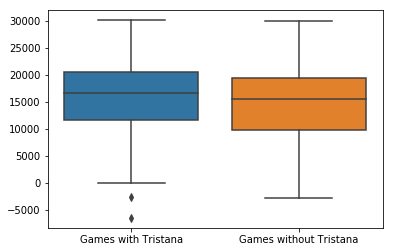

In [29]:
sns.boxplot(data=[trist_games['TurretDamageDiff'],notrist_games['TurretDamageDiff']]);
plt.xticks([0,1],['Games with Tristana','Games without Tristana']);

In [31]:
#Prepping for t-test

trist = trist_games['TurretDamageDiff']
notrist = notrist_games['TurretDamageDiff']

mean_trist = np.mean(trist)
mean_notrist = np.mean(notrist)

mean_diff = mean_trist - mean_notrist

sp.stats.ttest_ind(trist, notrist)

Ttest_indResult(statistic=1.0180431923248667, pvalue=0.30954577423399904)

In [32]:
#pvalue = 0.019...Interesting, what about all other champions?

#Generate a sample of games that Does have THE CHAMPION
turrets = ['Win_damageDealtToTurrets','Lose_damageDealtToTurrets','TurretDamageDiff']

champ_indexes = [col for col in yes.columns if 'championId' in col]  
champ_columns = yes[champ_indexes].reset_index(drop=True)

def champ_stats(name):
    '''Input a LoL champion to output the stats regarding turret damage
    win proportion, and p-values determining statistical significance of
    turret damage'''

    champ_index = []
    champ_wins = 0 # Initialize count
    win_check = 5 # We know the first five rows refer to the winning players 
    for index, row in champ_columns.iterrows():
        for position, key in enumerate(row):
            if key == champ_to_key[name]:
                champ_index.append(index)
                if position < win_check:
                    champ_wins += 1
                break 

    games_with = team[turrets].reset_index(drop=True).iloc[champ_index,:]
    games_with = games_with[~np.all(games_with == 0, axis=1)] # Removes rows where all values equal 0 

    #Generate a random sample of games that does NOT have THE CHAMPION

    np.random.seed(42)

    all_game_indexes = list(yes.reset_index(drop=True).index.values)
    nochamp_index = list(set(all_game_indexes) - set(champ_index))

    sample_nochamp_index = np.random.choice(nochamp_index, size = len(champ_index))
    nogames_with = team[turrets].reset_index(drop=True).iloc[sample_nochamp_index,:]
    nogames_with = nogames_with[~np.all(nogames_with == 0, axis=1)]
    
    games = games_with['TurretDamageDiff']
    nogames = nogames_with['TurretDamageDiff']
    
    sns.boxplot(data=[games, nogames]);
    plt.xticks([0,1],[f'Games with {name}',f'Games without {name}']);

    #Champ's winrate
    print(f"{name}'s winrate is", champ_wins/games_with.shape[0])
    
    #t-test results
    print(sp.stats.ttest_ind(games, nogames))



Yasuo's winrate is 0.567741935483871
Ttest_indResult(statistic=-0.019026386361659674, pvalue=0.9848322564900591)


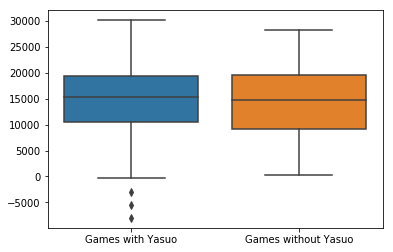

In [33]:
champ_stats('Yasuo')

In [ ]:
rune_indexes = [col for col in yes.columns if 'perk' in col]  
rune_columns = yes[rune_indexes].reset_index(drop=True)
rune_columns

In [ ]:
# Create a function similar to champ_stats, but with rune stats:

rune_indexes = [col for col in yes.columns if 'perk' in col]  
rune_columns = yes[rune_indexes].reset_index(drop=True)

def rune_stats(name):
    '''Input a LoL champion to output the stats regarding turret damage,
    win proportion, and p-values determining statistically significant 
    difference of turret damage'''

    rune_index = []
    rune_wins = 0
    win_check = 30 # 6 runes per player, thus the first 30 columns of rune_columns are refer to the winning team
    for index, row in rune_columns.iterrows():
        for position, key in enumerate(row):
            if key == rune_to_key[name]:
                rune_index.append(index)
                if position < win_check:
                    rune_wins += 1
                break 

    games_with = team[turrets].reset_index(drop=True).iloc[rune_index,:]
    games_with = games_with[~np.all(games_with == 0, axis=1)] # Removes rows where all values equal 0 

    #Generate a random sample of games that does NOT have THE CHAMPION

    np.random.seed(42) 
    
    
    all_game_indexes = list(yes.reset_index(drop=True).index.values)
    norune_index = list(set(all_game_indexes) - set(rune_index))

    sample_norune_index = np.random.choice(norune_index, size = len(rune_index))
    nogames_with = team[turrets].reset_index(drop=True).iloc[sample_norune_index,:]
    nogames_with = nogames_with[~np.all(nogames_with == 0, axis=1)]
    
    games = games_with['TurretDamageDiff']
    nogames = nogames_with['TurretDamageDiff']
    
    # Boxplot comparing Team Turret Damage from team least one player with the rune, to teams without rune
    sns.boxplot(data=[games, nogames]);
    plt.xticks([0,1],[f'Games with {name}',f'Games without {name}']);

    # Champ's winrate
    print(f"{name}'s winrate is", rune_wins/games_with.shape[0])
    
    # t-test results
    print(sp.stats.ttest_ind(games, nogames))

In [ ]:
rune_stats('Demolish')

In [ ]:
rune_index = []
rune_wins = 0
win_check = 30 # 6 runes per player, thus the first 30 columns of rune_columns are refer to the winning team
for index, row in rune_columns.iterrows():
    for position, key in enumerate(row):
        if key == rune_to_key['Electrocute']:
            rune_index.append(index)
            if position < win_check:
                rune_wins += 1
            break 

games_with = team[turrets].reset_index(drop=True).iloc[rune_index,:]
games_with = games_with[~np.all(games_with == 0, axis=1)] # Removes rows where all values equal 0 
rune_index

In [ ]:
turrets

In [ ]:
rune_to_key['Electrocute']

In [ ]:
for index, row in rune_columns.iterrows():
#    print(row)
    for position, key in enumerate(row):
        print(key)